In [1]:
from time import time

import numpy as np
import matplotlib.pyplot as plt

from patrolling_env.graph_env import GraphPatrolEnv
from patrolling_agents.rl_agent_2 import PatrolAgent2

from util import moving_average
from util.simulator import play_episodes_graph as simulate

# 1 - Training the agent

In [125]:
genv = GraphPatrolEnv('map_a.adj', 10, reward_type='avg_idleness')
#genv = GraphPatrolEnv('map_a.adj', 3, reward_type='visited_quadr_idleness')
#genv = GraphPatrolEnv('map_a.adj', 3, reward_type='visited_idleness')
#genv = GraphPatrolEnv('map_a.adj', 3, reward_type='delta_avg_idleness')


# obs.: a environment wrapper is instantiated inside the agent
#agent = PatrolAgent2(features='pidcq', learning_rate=0.0040, beta=0.05, n_step=3, beta_update=6, verbose=True, model='linear', shared_weights=True)
agent = PatrolAgent2(features='pidcq', learning_rate=0.0040, beta=0.05, n_step=3, beta_update=6, verbose=True, model='mlp', shared_weights=False)

start_time = time()
rewards, cumul_rewards = agent.train(genv, 20_000)
print("Time elapsed (s):", time() - start_time)

Step 1000, mean of last 1000 rewards: -5.302
Step 2000, mean of last 1000 rewards: -3.651
Step 3000, mean of last 1000 rewards: -3.676
Step 4000, mean of last 1000 rewards: -3.439
Step 5000, mean of last 1000 rewards: -3.545
Step 6000, mean of last 1000 rewards: -3.538
Step 7000, mean of last 1000 rewards: -3.587
Step 8000, mean of last 1000 rewards: -3.712
Step 9000, mean of last 1000 rewards: -3.594
Step 10000, mean of last 1000 rewards: -3.522
Step 11000, mean of last 1000 rewards: -3.689
Step 12000, mean of last 1000 rewards: -3.761
Step 13000, mean of last 1000 rewards: -3.758
Step 14000, mean of last 1000 rewards: -3.668
Step 15000, mean of last 1000 rewards: -4.119
Step 16000, mean of last 1000 rewards: -4.098
Step 17000, mean of last 1000 rewards: -4.128
Step 18000, mean of last 1000 rewards: -3.923
Step 19000, mean of last 1000 rewards: -3.812
Step 20000, mean of last 1000 rewards: -3.819
Time elapsed (s): 546.9167268276215


In [126]:
# Pesos das features -- só para modelo linear e sem pesos compartilhados !
# Considerar as features na ordem em que foram passadas para o construtor
# ex.: features='pidcq' --> pesos representam PresenceCount, Idleness, Degree, ConstantStat (1.0 for valid neighbors), Qualified Node Count

if agent.model == 'linear':
    if agent.shared_weights:
        print("Critic weights:", agent.critic.weights.view(-1).detach().numpy())
        print("Policy weights:", agent.policy.weights.view(-1).detach().numpy())
    else:
        for i in range(0,agent.num_agents):
            print(f"AGENT {i}")
            print(" - critic weights:", agent.critic.models[i].weights.view(-1).detach().numpy())
            print(" - policy weights:", agent.policy.models[i].weights.view(-1).detach().numpy())

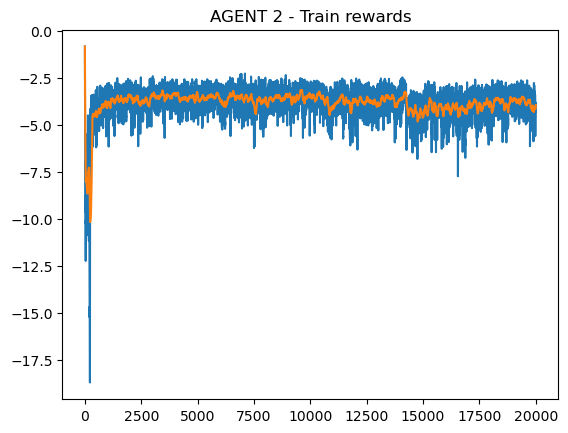

In [127]:
plt.plot(rewards)
plt.plot(moving_average(rewards, 100))
plt.title("AGENT 2 - Train rewards")
plt.show()

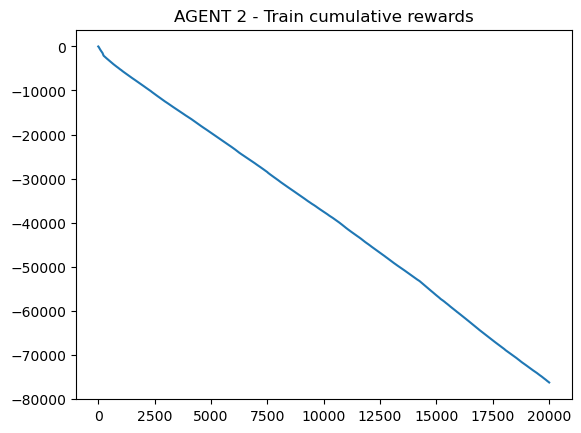

In [128]:
plt.plot(cumul_rewards)
plt.title("AGENT 2 - Train cumulative rewards")
plt.show()

# 2 - Simulating the trained agent

In [129]:
DETERMINISTIC = False

In [130]:
stats = simulate(agent.get_wrapper_env(), agent, max_steps=5_000, deterministic=DETERMINISTIC)


Episode 1 steps: 5000 , reward: -19373.240000000045
Total Results: 
 => mean reward: -19373.240000000045, episodes: 1, steps: 5000


In [131]:
#from patrolling_agents.local_stategies import LocalStrategy
#stats = simulate(genv, LocalStrategy(genv, 'RAND'), max_steps=5_000)

In [132]:
stats = np.asarray(stats)
stats

array([[33, 26, 41, ..., 42, 18, 27],
       [13,  1, 43, ..., 22,  4, 27],
       [41, 26, 41, ..., 21, 18, 27],
       ...,
       [17, 35, 39, ..., 37,  0, 16],
       [26,  7, 43, ..., 34, 12, 16],
       [ 1, 14, 39, ..., 45, 36, 16]])

# 3 - Evaluating the agent

In [133]:
import pandas as pd

In [134]:
NUM_NODES = 50
NUM_AGENTS = genv.num_agents

## 3.1 - Metrics based on number of visits

In [135]:
df = pd.DataFrame(columns=[ f'ag{i}' for i in range(NUM_AGENTS)], data=stats)
df = df.rename_axis('time', axis=0)
df

,ag0,ag1,ag2,ag3,ag4,ag5,ag6,ag7,ag8,ag9
time,,,,,,,,,,
0,33,26,41,9,16,8,46,42,18,27
1,13,1,43,9,16,20,23,22,4,27
2,41,26,41,32,18,8,46,21,18,27
3,36,17,43,9,4,2,37,40,4,27
4,48,24,39,29,45,30,12,10,45,27
...,...,...,...,...,...,...,...,...,...,...
4996,31,9,39,13,18,35,19,18,0,16
4997,24,29,43,33,46,29,6,46,23,16
4998,17,35,39,13,37,49,17,37,0,16


In [136]:
# ids of the nodes visited by each agent
#df = pd.DataFrame({'ag0': stats[:,0],'ag1': stats[:,1],'ag2': stats[:,2]})
#df = df.rename_axis('time', axis=0)
#df

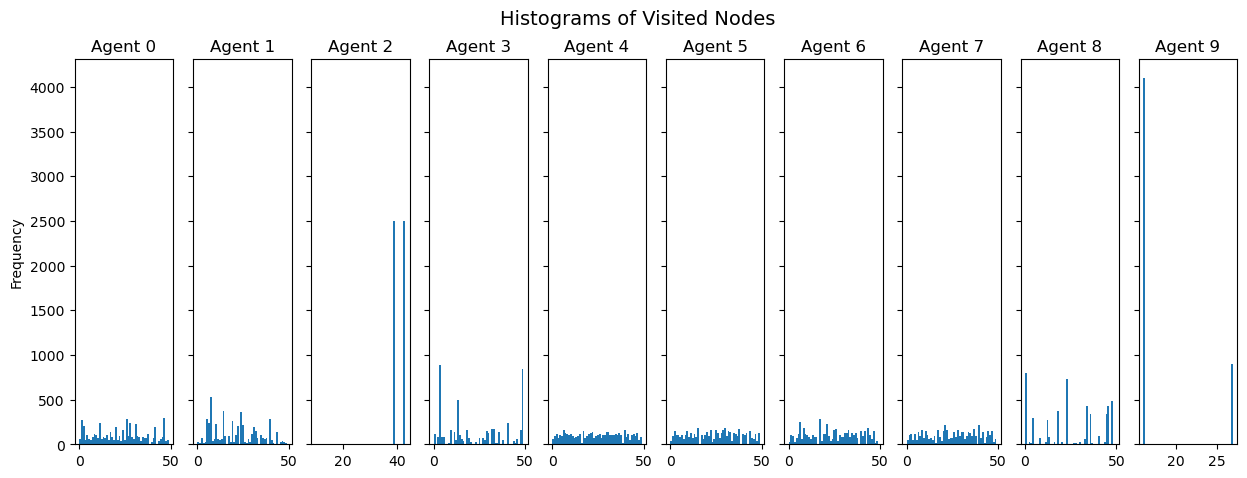

In [137]:
fig, axes = plt.subplots(1, NUM_AGENTS, figsize=(15, 5), sharey=True)  # Create a 1x3 grid of subplots
for i in range(NUM_AGENTS):
    df[f'ag{i}'].plot.hist(ax=axes[i], bins=50, title=f'Agent {i}')

#plt.tight_layout()  # Ensures subplots do not overlap
plt.suptitle('Histograms of Visited Nodes', fontsize=14) ;

In [138]:
# para cada agente e cada nó, indica quantas visitas
#df_node = pd.DataFrame(index=range(0,NUM_NODES), data = {'ag0' : df['ag0'].value_counts(), 'ag1' : df['ag1'].value_counts(), 'ag2' : df['ag2'].value_counts()})
df_node = pd.DataFrame(index=range(0,NUM_NODES), data = { agent_name : df[agent_name].value_counts() for agent_name in df.columns})
df_node = df_node.rename_axis('node', axis=0)
df_node.head(10)

,ag0,ag1,ag2,ag3,ag4,ag5,ag6,ag7,ag8,ag9
node,,,,,,,,,,
0,54.0,20.0,NaN,120.0,57,40,30.0,45,797.0,NaN
1,270.0,13.0,NaN,1.0,90,92,99.0,100,NaN,NaN
2,208.0,73.0,NaN,85.0,111,150,96.0,120,20.0,NaN
3,43.0,15.0,NaN,886.0,70,106,27.0,43,10.0,NaN
4,103.0,28.0,NaN,87.0,107,99,70.0,119,298.0,NaN
5,57.0,286.0,NaN,87.0,90,87,112.0,44,2.0,NaN
6,50.0,235.0,NaN,1.0,157,108,250.0,138,NaN,NaN
7,79.0,527.0,NaN,7.0,127,54,60.0,96,NaN,NaN
8,110.0,42.0,NaN,12.0,115,103,178.0,158,65.0,NaN


In [139]:
# pouco visível
#plt.figure(figsize=(15,5))
#df_node.plot.bar()

<AxesSubplot:title={'center':'Total Visits per Node'}, xlabel='node'>

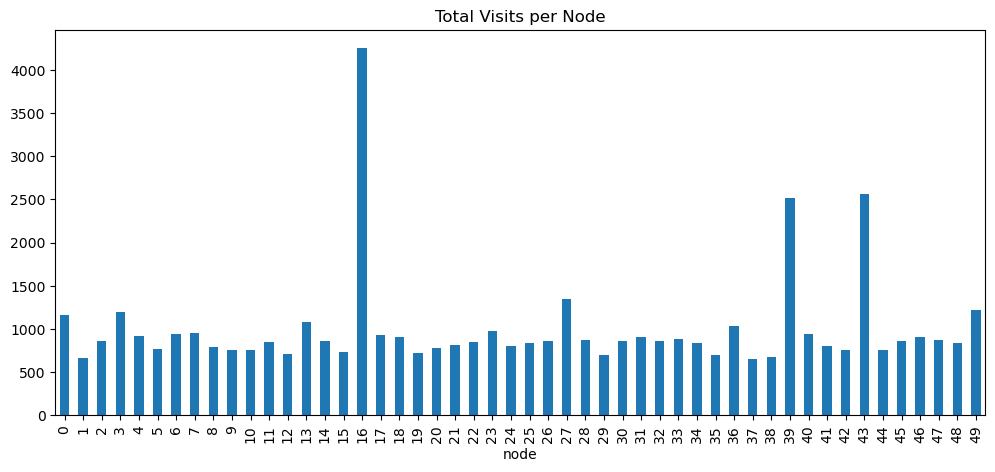

In [140]:
df_node_freqs = df_node.sum(axis=1)

plt.figure(figsize=(12,5))
plt.title('Total Visits per Node')
df_node_freqs.plot.bar()

In [141]:
TOTAL_TIME = (df.shape[0]-1)
df_node_freqs = df_node_freqs /  TOTAL_TIME

avg_freq = df_node_freqs.mean()
min_freq = df_node_freqs.min()
stdev_freq = df_node_freqs.std()

In [142]:
print("AVERAGE FREQUENCY / 100k turns:", 100_000*avg_freq)
print("MIN FREQUENCY / 100K turns:", 100_000*min_freq)
print("STANDARD DEVIATION OF FREQ / 100k turns:", 100_000*stdev_freq)

AVERAGE FREQUENCY / 100k turns: 20004.000000000004
MIN FREQUENCY / 100K turns: 13060.0
STANDARD DEVIATION OF FREQ / 100k turns: 11854.474054214334


## 3.2 - Metrics based on intervals

In [143]:
from tqdm.notebook import tqdm_notebook as tqdm

Calcula, para cada nó, os instantes das visitas que ele recebeu (não importa por qual agente).

In [144]:
# Iterate through df columns
#node_visits = [ [] for i in range(NUM_NODES) ]
#for agent in df.columns:
#    for timestamp, node_id in enumerate(df[agent]):
#        node_visits[node_id].append(timestamp)
#plt.bar(range(50), [ len(l) for l in node_visits ])

In [145]:
# Iterate through df rows 
# Advantage: timestamps (per node) are ordered
node_visit_times = [ [] for i in range(NUM_NODES) ]
for timestamp, row in df.iterrows():
    for ag_id, node_id in enumerate(row):
        node_visit_times[node_id].append(timestamp)

#plt.bar(range(50), [ len(l) for l in node_visits ])

In [146]:
redundant_visits = 0
for node in tqdm(range(len(node_visit_times))):
    for i, ts in enumerate(set(node_visit_times[node])):
        # quantas visitas recebeu no mesmo timestamp 'ts'
        count = node_visit_times[node].count(ts)
        if count > 1:
            redundant_visits += count - 1
            #print(f'{node=}, {ts=}', node_visits[node].count(ts))

print("Redundant visits:", redundant_visits)

  0%|          | 0/50 [00:00<?, ?it/s]

Redundant visits: 6800


In [147]:
# testando para um dos timestamps se vários agentes estavam lá
#df.loc[4068]

Calcular intervalos.

In [148]:
# Clona o node_visits
nd_visits_clone = [ list(node_visit_times[n]) for n in range(NUM_NODES) ]

# Adiciona o tempo final...
last_ts = df.shape[0]-1
for node in range(NUM_NODES):
    if nd_visits_clone[node][-1] != last_ts:
        nd_visits_clone[node].append(last_ts)


In [149]:
#display(df.tail(1))
nd_visits_clone[4][-10:]

[4953, 4953, 4953, 4963, 4967, 4976, 4982, 4995, 4995, 5000]

In [150]:
# Intervalos calculados pelas diferenças dos timestamps
node_intervals = [ ]
for node in range(NUM_NODES):
    nd_interval_list = nd_visits_clone[node]
    node_intervals.append( [ (nd_interval_list[i+1] - nd_interval_list[i]) for i in range(len(nd_interval_list)-1) ] )

In [151]:
# alternative computation for redudant visits
redundant = 0
for node in range(NUM_NODES):
    redundant += node_intervals[node].count(0)
redundant

6800

In [152]:
flat_intervals = [interval for single_node_intervals in node_intervals for interval in single_node_intervals]
flat_squared_intervals = [interval*interval for interval in flat_intervals]

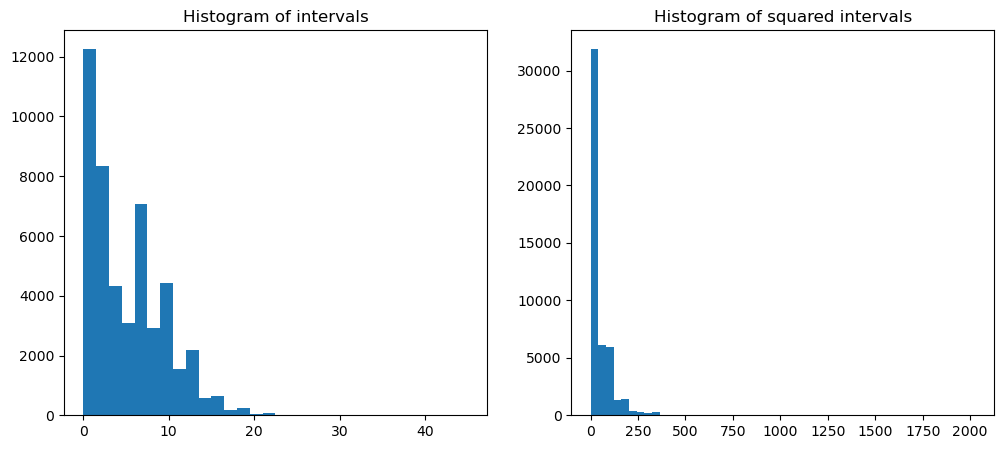

In [153]:
fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # Create a 1x2 grid of subplots
axes[0].hist(flat_intervals[2000:], bins=30)
axes[0].set_title('Histogram of intervals')

axes[1].hist(np.square(flat_intervals[2000:]), bins=50)
axes[1].set_title('Histogram of squared intervals');


In [154]:
average_interval = np.mean(flat_intervals)
max_interval = np.max(flat_intervals)
#quadratic_mean_interval = np.mean( np.square(flat_intervals) )
quadratic_mean_interval = np.mean( flat_squared_intervals )
standard_dev_interval = np.std(flat_intervals)

## 3.3 - Metrics based on idleness

In [155]:
# Falta: remover a visita final acrescentada para calcular intervalos

instantaneous_idleness = [0] * NUM_NODES
node_visit_index = [0] * NUM_NODES

average_global_idleness = 0
#total_time = df.shape[0]-1

for t in tqdm(df.index[1:]):
    for n in range(NUM_NODES):
        idx = node_visit_index[n]
        while idx < (len(node_visit_times[n])-1) and node_visit_times[n][idx] < t:
            idx += 1
        node_visit_index[n] = idx
        #assert idx >= len(node_visits[n])-1 or node_visits[n][idx] >= t, f'{t=} {n=} {idx=} node-visit-time={node_visits[n][idx]}'
        if node_visit_times[n][idx] == t:
            instantaneous_idleness[n] = 1
        else:
            instantaneous_idleness[n] += 1
    
    average_global_idleness += np.mean(instantaneous_idleness) * (1.0 / TOTAL_TIME)
    #print(instantaneous_idleness)

  0%|          | 0/5000 [00:00<?, ?it/s]

In [156]:
print("AVG INTERVAL:", average_interval)
print("MAX INTERVAL:", max_interval)
print("QMI:", quadratic_mean_interval)
print("REDUNDANT VISITS:", redundant_visits)
print("STD DEVIATION OF INTERVALS:", standard_dev_interval)
print("AVERAGE IDLENESS:", average_global_idleness)

AVG INTERVAL: 4.996080078398432
MAX INTERVAL: 45
QMI: 43.71178576428471
REDUNDANT VISITS: 6800
STD DEVIATION OF INTERVALS: 4.330238978915024
AVERAGE IDLENESS: 4.873960000000015


---
Resultados dados como - AVG_INT / MAX_INT / QMI / REDUND / STDDEV_INT / AVG_IDLENESS

---

Random: 16 / 416 / 994 / 312 / 26 / 30

---
Com escolha **não-determinística** (padrão):

Sem compartilhar pesos, treinando por 15_000 e simulando por 5_000:
- Com metrica 'avg_idleness'            --> 16 / 69 / 373
  - +MLP --> 16 / 71 / 369 / 1282 / 9.6 / 11.59
- Com metrica 'visited_quadr_idleness'  --> 16 / 73 / 381
- Com metrica 'visited_idleness'        --> 16 / 76 / 375
- Com métrica 'delta_avg_idleness'      --> 16 / 74 / 374 / 1229
  - +MLP  --> 16 / 73 / 373 / 1107 / 9.8 / 11.72

Compartilhando pesos:
- 'avg_idleness'            --> 16 / 59 / 372
- 'visited_quadr_idleness'  --> 16 / 71 / 373
- 'visited_idleness'        --> 16 / 71 / 374
- 'delta_avg_idleness'      --> 16 / 75 / 375 / redundant? / 9.9

---
Com escolha **determinística**:

Sem compartilhar pesos, treinando por 15_000 e simulando por 5_000:
- 'avg_idleness'            --> 16 / 60 / 497 / 6621
- 'visited_quadr_idleness'  --> 16 / 86 / 485 / 4760
- 'visited_idleness'        --> 16 / 71 / 489 / 5076
- 'delta_avg_idleness'      --> 16 / 78 / 470 / 4527

Compartilhando pesos:
- 'avg_idleness'            --> 16 / 82 / 485 / 5409
- 'visited_quadr_idleness'  --> 16 / 91 / 460 / 4392
- 'visited_idleness'        --> 16 / 81 / 479 / 4683
- 'delta_avg_idleness'      --> 16 / 90 / 506 / 5057
---

In [157]:
from util.metrics import calculate_metrics

metrics = calculate_metrics(stats, NUM_NODES, NUM_AGENTS)
metrics

{'frequency': {'avg': 0.20004000000000002,
  'min': 0.1306,
  'std dev': 0.11854474054214334},
 'interval': {'avg': 4.996080078398432,
  'max': 45,
  'quadratic mean': 43.71178576428471,
  'std dev': 4.330238978915024},
 'idleness': {'avg': 4.873960000000015},
 'others': {'redundant visits': 6800}}

**NON-SHARED MLP**
```
{'frequency': {'avg': 0.20003999999999997,
  'min': 0.1064,
  'std dev': 0.10142623739769242},
 'interval': {'avg': 4.995140194392224,
  'max': 40,
  'quadratic mean': 41.60947562097516,
  'std dev': 4.08142745364197},
 'idleness': {'avg': 4.665212000000029},
 'others': {'redundant visits': 5743}}
```

**SHARED LINEAR**
```
{'frequency': {'avg': 0.20004000000000005,
  'min': 0.1498,
  'std dev': 0.01986398648770366},
 'interval': {'avg': 4.99630014799408,
  'max': 29,
  'quadratic mean': 39.45604175832967,
  'std dev': 3.806970789155598},
 'idleness': {'avg': 4.448072000000007},
 'others': {'redundant visits': 10459}}
```